# Problem Definition: 

**Utilizing ESG data to construct a long short strategy, a backtesting engine, and portfolio statistics based on backtesting the ESG data**

Install and Import the required dependencies

In [1]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install yfinance
! pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
# import warnings
# warnings.filterwarnings("ignore")
import seaborn as sns
import random
sns.set()
size = 18
params = {'legend.fontsize': 'large',
          'figure.figsize': (15,8),
          'axes.labelsize': size * 0.8,
          'axes.titlesize': size * 0.95,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

# MSCI Ranking Data Prepration

Install required scraping libraries

In [3]:
%%capture
!pip install selenium
!pip install py-msci-esg

In [4]:
%%capture
!wget https://bitbucket.org/ariya/phantomjs/downloads/phantomjs-2.1.1-linux-x86_64.tar.bz2
!tar xvjf phantomjs-2.1.1-linux-x86_64.tar.bz2
!cp phantomjs-2.1.1-linux-x86_64/bin/phantomjs /usr/local/bin
!ls -al

Scrape for S&P Constituents and Grab Wikipedia Page

In [6]:
import pandas as pd
import html5lib
from bs4 import BeautifulSoup
import requests
# Scrape the entire S&P500 list from Wikipedia into a Pandas DataFrame;
ticker_list = pd.read_html(
'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = ticker_list[0]
# Drop a few unwanted columns of data;
df.drop(columns = ['SEC filings', 'Date first added', 'Founded'], inplace = True)
# Fill out CIK codes by converting to string then adding in 0's up to 10 digits.
df.CIK = df.CIK.astype(str)
df['CIK'] = df['CIK'].str.zfill(10)
request = requests.get(
'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df['WIKI_URL'] = ''
soup = BeautifulSoup(request.content)
main_table = soup.find(id='constituents')
table = main_table.find('tbody').findAll('tr')
table = table[1:]
base_url = 'https://en.wikipedia.org'
url_list = []
for item in table:
    url = base_url + str(item.findAll('a')[1]['href'])
    url_list.append(url)
    
df['WIKI_URL'] = url_list
df = df[df["Symbol"]!="POOL"].reset_index(drop=True)
df.tail()
df["Search"] = df["WIKI_URL"].str.split("https://en.wikipedia.org/wiki/").apply(lambda x: x[1])
import json
apps = []

for name in df["Search"].to_list():
  r = requests.get("https://en.wikipedia.org/w/api.php?action=query&format=json&titles="+name+"&redirects", allow_redirects=False)
  data = json.loads(r.text)
  try:
    dal = data["query"]["redirects"][0]["to"]
  except:
    try:
      dal = data["query"]["normalized"][0]["to"]
    except:
      dal = name
  apps.append(dal)
df["clean_search"] = apps

In [7]:
df.head(5)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,CIK,WIKI_URL,Search,clean_search
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",0000066740,https://en.wikipedia.org/wiki/3M,3M,3M
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",0000091142,https://en.wikipedia.org/wiki/A._O._Smith,A._O._Smith,A. O. Smith
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",0000001800,https://en.wikipedia.org/wiki/Abbott_Laboratories,Abbott_Laboratories,Abbott Laboratories
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",0001551152,https://en.wikipedia.org/wiki/AbbVie,AbbVie,AbbVie
4,ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",0000815094,https://en.wikipedia.org/wiki/Abiomed,Abiomed,Abiomed


In [8]:
!wget https://open-data.s3.filebase.com/rep_full.p

--2022-11-03 00:18:09--  https://open-data.s3.filebase.com/rep_full.p
Resolving open-data.s3.filebase.com (open-data.s3.filebase.com)... 51.81.66.104, 51.81.56.185, 51.81.107.75
Connecting to open-data.s3.filebase.com (open-data.s3.filebase.com)|51.81.66.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108374 (106K) [application/octet-stream]
Saving to: ‘rep_full.p.2’

rep_full.p.2        100%[===================>] 105.83K   461KB/s    in 0.2s    

2022-11-03 00:18:10 (461 KB/s) - ‘rep_full.p.2’ saved [108374/108374]



In [9]:
import pickle 
import pandas as pd

rep_full = pickle.load(open("rep_full.p", "rb"))
df = pd.DataFrame.from_dict(rep_full)

In [10]:
df.shape

(4, 505)

In [11]:
df.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,AYI,ADBE,AAP,AMD,...,WYNN,XEL,XRX,XLNX,XL,XYL,YUM,ZBH,ZION,ZTS
rating-paragraph,3M is a leader among 36 companies in the indus...,A. O. Smith is average among 24 companies in t...,NaN,AbbVie is average among 39 companies in the bi...,Accenture is average among 143 companies in th...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,XYLEM is a leader among 51 companies in the in...,NaN,Zimmer Biomet is a laggard among 93 companies ...,NaN,Zoetis is a leader among 99 companies in the p...
rating-history-paragraph,"3M's rating remains unchanged since August, 2017.",A. O. Smith's rating remains unchanged since F...,NaN,AbbVie's rating remains unchanged since Octobe...,"Accenture was downgraded in December, 2020.",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,XYLEM's rating remains unchanged since Februar...,NaN,"Zimmer Biomet was upgraded in May, 2020.",NaN,"Zoetis was upgraded in March, 2021."
current,"{'esg_rating': 'aaa', 'esg_category': 'leader'}","{'esg_rating': 'bbb', 'esg_category': 'average'}",NaN,"{'esg_rating': 'a', 'esg_category': 'average'}","{'esg_rating': 'a', 'esg_category': 'average'}",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",NaN,"{'esg_rating': 'b', 'esg_category': 'laggard'}",NaN,"{'esg_rating': 'aa', 'esg_category': 'leader'}"
history,"{'sep-16': 'aaa', 'aug-17': 'aaa', 'aug-18': '...","{'feb-17': 'bbb', 'feb-18': 'bb', 'feb-19': 'b...",NaN,"{'oct-16': 'bbb', 'oct-17': 'bbb', 'oct-18': '...","{'jun-17': 'aaa', 'jun-18': 'aaa', 'mar-19': '...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'feb-17': 'aa', 'feb-18': 'aa', 'feb-19': 'aa...",NaN,"{'dec-16': 'ccc', 'dec-17': 'ccc', 'dec-18': '...",NaN,"{'sep-17': 'aa', 'dec-18': 'a', 'jun-19': 'a',..."


In [12]:
df = df[df.index=="current"].dropna(axis=1).T

In [13]:
df["current"][0]

{'esg_rating': 'aaa', 'esg_category': 'leader'}

In [14]:
df.iloc[0][0]["esg_rating"]

'aaa'

In [15]:
df["risk"] = df["current"].apply(lambda x: x["esg_rating"])

In [16]:
rep = {"ccc":7, "b":6, "bb":5, "bbb":4, "a":3, "aa":2, "aaa":1}

In [17]:
df.index.name = "Ticker"

In [18]:
df=df.replace({"risk": rep})

In [19]:
df["risk"] = df["risk"]/df["risk"].max()

In [20]:
df = df.reset_index()

In [21]:
df.head()

,Ticker,current,risk
0,MMM,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
1,AOS,"{'esg_rating': 'bbb', 'esg_category': 'average'}",0.571429
2,ABBV,"{'esg_rating': 'a', 'esg_category': 'average'}",0.428571
3,ACN,"{'esg_rating': 'a', 'esg_category': 'average'}",0.428571
4,AES,"{'esg_rating': 'a', 'esg_category': 'average'}",0.428571


In [22]:
df.sort_values("risk")

,Ticker,current,risk
0,MMM,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
89,ECL,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
101,EXPD,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
123,GWW,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
154,JCI,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
...,...,...,...
203,NWSA,"{'esg_rating': 'ccc', 'esg_category': 'laggard'}",1.000000
204,NWS,"{'esg_rating': 'ccc', 'esg_category': 'laggard'}",1.000000
83,DISH,"{'esg_rating': 'ccc', 'esg_category': 'laggard'}",1.000000
152,SJM,"{'esg_rating': 'ccc', 'esg_category': 'laggard'}",1.000000


# Pricing Data Preparation 

Download the S&P Constituents pricing data from yahoofinance

In [23]:
prices=pd.DataFrame()
nullname=[]
index=0
error = []
for i in df['Ticker']:
  try:
    yfdata=yf.download(i,start="2018-01-01",end="2021-01-01",interval = '1mo')["Adj Close"]
    prices[i] = yfdata
  except:
      error.append(i)
      index += 1

print(prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 168, in history
    end = utils._parse_user_dt(end, tz)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/utils.py", line 157, in _parse_user_dt
    dt = _tz.timezone(exchange_tz).localize(dt)
  File "/usr/local/lib/python3.7/dist-packages/pytz/__init__.py", line 170, in timezone
    if zo

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exception in thread Thread-22:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 168, in history
    end = utils._parse_user_dt(end, tz)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/utils.py", line 157, in _parse_user_dt
    dt = _tz.timezone(exchange_tz).localize(dt)
  File "/usr/local/lib/python3.7/dist-packages/pytz/__init__.py", line 170, in timezone
    if zo

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Exception in thread Thread-41:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 168, in history
    end = utils._parse_user_dt(end, tz)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/utils.py", line 157, in _parse_user_dt
    dt = _tz.timezone(exchange_tz).localize(dt)
  File "/usr/local/lib/python3.7/dist-packages/pytz/__init__.py", line 170, in timezone
    if zo

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BF.B: No dat

Exception in thread Thread-58:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 168, in history
    end = utils._parse_user_dt(end, tz)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/utils.py", line 157, in _parse_user_dt
    dt = _tz.timezone(exchange_tz).localize(dt)
  File "/usr/local/lib/python3.7/dist-packages/pytz/__init__.py", line 170, in timezone
    if zo

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exception in thread Thread-65:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 168, in history
    end = utils._parse_user_dt(end, tz)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/utils.py", line 157, in _parse_user_dt
    dt = _tz.timezone(exchange_tz).localize(dt)
  File "/usr/local/lib/python3.7/dist-packages/pytz/__init__.py", line 170, in timezone
    if zo

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CHK: Data doesn't exist for startDate = 1514782800, endDate = 1609477200
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*******

Exception in thread Thread-93:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 168, in history
    end = utils._parse_user_dt(end, tz)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/utils.py", line 157, in _parse_user_dt
    dt = _tz.timezone(exchange_tz).localize(dt)
  File "/usr/local/lib/python3.7/dist-packages/pytz/__init__.py", line 170, in timezone
    if zo

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Exception in thread Thread-116:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 168, in history
    end = utils._parse_user_dt(end, tz)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/utils.py", line 157, in _parse_user_dt
    dt = _tz.timezone(exchange_tz).localize(dt)
  File "/usr/local/lib/python3.7/dist-packages/pytz/__init__.py", line 170, in timezone
    if z

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
Exception in thread Thread-167:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/li

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
Exception in thread Thread-175:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/li

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MON: Data doesn't exist for startDate = 1514782800, endDate = 1609477200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
Exception in thread Thread-207:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/mult

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PX: Data doesn't exist for startDate = 1514782800, endDate = 1609477200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- COL: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SCG: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exception in thread Thread-265:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 201, in _download_one_threaded
    keepna, timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 218, in _download_one
    timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 168, in history
    end = utils._parse_user_dt(end, tz)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/utils.py", line 157, in _parse_user_dt
    dt = _tz.timezone(exchange_tz).localize(dt)
  File "/usr/local/lib/python3.7/dist-packages/pytz/__init__.py", line 170, in timezone
    if z


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  



[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
Exception in thread Thread-287:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/mult

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  



[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WYN: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   MMM        AOS       ABBV         ACN        AES  \
Date                                                                  
2018-01-01  214.100571  61.130051  88.968468  149.509338   9.863911   
2018-02-01  201.288773  58.917892  92.489220  149.797745   9.380180   
2018-03-01  188.728531  58.367168  75.577187  142.810745   9.811649   
2018-04-01  167.123505  56.311150  77.094315  140.670837  10.562409   
2018-05-01  169.565125  58.056679  79.821030  146.173309  11.119945   
2018-06-01  170.283356  54.448280  74.746490  153.541107  11.695563   
2018-07-01  183.786911  54.798077  74.407661  149.542770  11.651956   
2018-08-01  182.575073  53.626583  78.223824  158.684525  11.739172   
2018-09-01  183.615845  49.277725  77.082825  159.745087  12.329123   
2018-10-01  165.795395  42.038887  63.447849  147.937851  12.839900   
2018-11-01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [24]:
prices=prices.dropna(axis=1)
prices.head()

,MMM,AOS,ABBV,ACN,AES,AFL,A,AKAM,ALGN,ALLE,...,WM,WAT,WFC,WDC,WU,WY,WMB,XYL,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,214.100571,61.130051,88.968468,149.509338,9.863911,39.296978,70.814560,66.989998,262.000000,81.463646,...,81.081451,215.610001,57.306419,81.621170,16.975792,30.947805,23.390779,68.236534,118.963676,74.401764
2018-02-01,201.288773,58.917892,92.489220,149.797745,9.380180,39.599945,66.146942,67.459999,262.519989,79.571579,...,79.146805,204.639999,50.885803,79.841606,16.183746,28.878574,20.685825,70.427368,108.791115,78.535324
2018-03-01,188.728531,58.367168,75.577187,142.810745,9.811649,39.221497,64.517159,70.980003,251.130005,80.687912,...,77.129639,198.649994,45.931023,84.639084,15.701987,28.853842,18.524843,72.847290,102.043732,81.109146
2018-04-01,167.123505,56.311150,77.094315,140.670837,10.562409,40.843781,63.398460,71.650002,249.850006,73.194038,...,74.943336,188.410004,45.536644,72.668060,16.278873,30.600805,19.413509,69.040154,108.019394,81.080032
2018-05-01,169.565125,58.056679,79.821030,146.173309,11.119945,40.386673,59.847813,75.379997,331.950012,72.482788,...,76.252464,192.619995,47.315704,77.021324,16.394270,31.058407,20.266106,66.672501,104.586647,81.413033


In [25]:
df_rank_risk=pd.DataFrame()
nullname=[]
index=0
error = []

for i in df['Ticker']:
  try:
    df_rank_risk[i] = prices[i].pct_change()
  except:
      error.append(i)
      index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [26]:
df_rank_risk = df_rank_risk.dropna()
df_rank_risk.reset_index(inplace = True)
df_rank_risk.set_index(df_rank_risk['Date'], inplace = True)
df_rank_risk.head()

,Date,MMM,AOS,ABBV,ACN,AES,AFL,A,AKAM,ALGN,...,WM,WAT,WFC,WDC,WU,WY,WMB,XYL,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,2018-02-01,-0.059840,-0.036188,0.039573,0.001929,-0.049040,0.007710,-0.065913,0.007016,0.001985,...,-0.023861,-0.050879,-0.112040,-0.021803,-0.046657,-0.066862,-0.115642,0.032106,-0.085510,0.055557
2018-03-01,2018-03-01,-0.062399,-0.009347,-0.182854,-0.046643,0.045998,-0.009557,-0.024639,0.052179,-0.043387,...,-0.025486,-0.029271,-0.097371,0.060087,-0.029768,-0.000856,-0.104467,0.034361,-0.062021,0.032773
2018-04-01,2018-04-01,-0.114477,-0.035226,0.020074,-0.014984,0.076517,0.041362,-0.017340,0.009439,-0.005097,...,-0.028346,-0.051548,-0.008586,-0.141436,0.036740,0.060545,0.047972,-0.052262,0.058560,-0.000359
2018-05-01,2018-05-01,0.014610,0.030998,0.035369,0.039116,0.052785,-0.011192,-0.056005,0.052059,0.328597,...,0.017468,0.022345,0.039069,0.059906,0.007089,0.014954,0.043918,-0.034294,-0.031779,0.004107
2018-06-01,2018-06-01,0.004236,-0.062153,-0.063574,0.050405,0.051765,-0.039816,-0.001292,-0.028522,0.030697,...,-0.016564,0.005036,0.034588,-0.073045,0.022122,-0.023306,0.009308,-0.040102,-0.000628,0.017802


# Performing a long-short strategy:  
We choose the median of risk to be our quantitaive factor, and： 

a. We backtest a strategy of longing low-risk stocks and shorting high-risk stocks. More specifically, taking a long position in the bottom 10% of stocks based on risk and take a short position in the top 10% of stocks based on risk. 

b. The backtesting should be done only for stocks in the S&P 500 universe, on a monthly basis. The long basket will hold approximately 20 low risk stocks and the short basket will hold approximately 20 high risk stocks at each Pointdate.

Note that the S&P 500 typically has 500 stocks at each Pointdate but occasionally a few more or a few less stocks are introduced. 

# Constructing the portfolio

In [27]:
class PortfolioConstruction:
    
    def __init__(self, df_rank_risk, rebalancing_period = 20, pick_percent = 10, strategy = "equal_weighted"):
        
        #Intializethe portfolio weights dataframe with 0 values
        self.weights = pd.DataFrame(0, index = df_rank_risk.index, columns=df_rank_risk.columns[1:]).reset_index()
        self.weights['Date'] = pd.to_datetime(self.weights['Date'])
        
        #Set starting date and max date with pandas index
        self.curr_index = 0
        self.max_index = len(df_rank_risk)
        
        #Set Monthly Portfolio Rebalancing period (Assuming 20 trading days in a month)
        self.rebalancing_period = rebalancing_period
        
        #Intialize other parameters
        self.pick_percent = pick_percent
        self.strategy = strategy
        
    def longShortStrategy(self):
        
        if self.strategy == "equal_weighted":
            self.equalWeightedAllocation()
        
        elif self.strategy == "rank_weighted":
            self.rankWeightedStrategy()
            
        return self.weights
    
    def equalWeightedAllocation(self):
        
        while self.curr_index <= self.max_index:
            
            #Select top 10% and bottom 10% of the total stocks on SNP 500 based on rank of beta.
            total_stocks = np.max(df_rank_risk.iloc[self.curr_index, 1:])
            pick_stocks = int(round(total_stocks * 100 * (self.pick_percent / 100), 0))
            conditions = [df_rank_risk.iloc[self.curr_index, 1:] >= total_stocks - pick_stocks, df_rank_risk.iloc[self.curr_index, 1:] <= pick_stocks]
            
            #Assign equal weights to bottom 10% of stocks and top 10% of stocks (Dollar Neutral)
            weights = 1 / (2 * pick_stocks)
            long_short_weights = [-weights, weights]
            self.weights.iloc[self.curr_index: self.curr_index + self.rebalancing_period, 1:] = np.select(conditions, long_short_weights, default = 0)
            
            #Update current index according to the rebalancing period
            self.curr_index += self.rebalancing_period 
    
    
    def rankWeightedAllocation(self):
        
        pass


In [28]:
portfolio_obj = PortfolioConstruction(df_rank_risk, rebalancing_period = 20, pick_percent = 10, strategy = "equal_weighted")
df_weights = portfolio_obj.longShortStrategy()
df_weights

,Date,MMM,AOS,ABBV,ACN,AES,AFL,A,AKAM,ALGN,...,WM,WAT,WFC,WDC,WU,WY,WMB,XYL,ZBH,ZTS
0,2018-02-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
1,2018-03-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
2,2018-04-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
3,2018-05-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
4,2018-06-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
5,2018-07-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
6,2018-08-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
7,2018-09-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
8,2018-10-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250
9,2018-11-01,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,...,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250,-0.250


# Compute Portfolio Statistics
The tasks are as follows: 

a. For the backtested portfolio, calculate a number of statistics.

b. Time series number of stocks in the long/short portfolio. This should typically be 100 stocks at each Pointdate 

c. Time series of cumulative wealth curve of the long/short portfolio. Start the wealth curve at $100. 

d. Time series of the long/short portfolio turnover. The maximum turnover is 400%. Turnover is based on the number of stocks that enter and leave the long portfolio as well as the number of stocks that enter and leave the short portfolio. 

e. The overall long/short portfolio annualized return, annualized volatility, and Sharpe ratio. 

f. Provide graphical charts of the above calculated metrics with appropriate axis titles. But if you are unfamiliar with charting in Python, then ignore this step. 

In [29]:
class PortfolioStatistics:
    
    def __init__(self, portfolio_weights, stock_daily_returns):
        
        #Start with 100$
        self.starting_wealth = 100
        
        self.portfolio_weights = portfolio_weights
        self.stock_daily_returns = stock_daily_returns
        self.total_days = len(self.portfolio_weights)
        
        #Remove those stocks from daily returns which are absent in the portfolio
        cols_remove = set(self.stock_daily_returns.columns) - set(self.portfolio_weights.columns)
        self.stock_daily_returns.drop(columns=cols_remove, inplace=True)
        
        #Set Stock returns starting date to match with Portfolio weights starting date
        self.stock_daily_returns = self.stock_daily_returns.loc[self.stock_daily_returns['Date'] >= min(self.portfolio_weights['Date'])]
        self.stock_daily_returns.reset_index(drop=True, inplace=True)
        
    
    def portfolioReturns(self):
        
        #Create a Portfolio Statistics dataframe
        self.portfolio_returns = pd.DataFrame(0, index = self.portfolio_weights['Date'], columns=['Daily_Returns', 'Cumulative_Returns']).reset_index()
        self.portfolio_returns['Date'] = pd.to_datetime(self.portfolio_returns['Date'])
        
        #Compute daily and cumulative Returns of the Portfolio
        self.portfolio_returns['Daily_Returns'] = np.multiply(self.stock_daily_returns.iloc[:, 1:], self.portfolio_weights.iloc[:,1:]).sum(axis = 1)
        self.portfolio_returns['Cumulative_Returns'] = self.starting_wealth * np.cumprod(1 + self.portfolio_returns['Daily_Returns'])
        
        return self.portfolio_returns
    
    def numberOfStocks(self):
        
        self.num_stocks = pd.DataFrame(0, index = self.portfolio_weights['Date'], columns=['Total_Stocks']).reset_index()
        self.num_stocks['Pointdate'] = pd.to_datetime(self.num_stocks['Date'])

        self.num_stocks['Total_Stocks'] = self.portfolio_weights.iloc[:,1:].astype(bool).sum(axis=1)
        return self.num_stocks
    
    def annualizedReturns(self):
        
        # Here we assume 252 trading days
        return round((np.prod(1 + self.portfolio_returns['Daily_Returns']) ** (252/self.total_days) - 1) * 100, 3)
    
    def annualizedVolatility(self, days = 252):
        
        return round(self.portfolio_returns['Daily_Returns'].std() * np.sqrt(days), 3)
     
    def annualizedSharpe(self, treasury_rate = 0.017, days=252):
        
        volatility = self.portfolio_returns['Daily_Returns'].std()* np.sqrt(days)
        sharpe = ((self.portfolio_returns['Daily_Returns'].mean() - treasury_rate) / volatility) 
        return round(sharpe, 3)
    
    def turnover(self):
        
        daily_turnover = abs(self.portfolio_weights.iloc[1:, 1:] - self.portfolio_weights.shift(1).iloc[1:, 1:]).sum(axis = 1) * 100
        total_turnover = round((sum(daily_turnover)/(len(daily_turnover) - 1)), 3)
        
        return daily_turnover, total_turnover
    
    def maxDrawdown(self, cumulative_returns):
        
        try:
            
            i = np.argmax((np.maximum.accumulate(cumulative_returns) - cumulative_returns)/cumulative_returns) # end of the period
            j = np.argmax(cumulative_returns[:i]) # start of period

            max_drawdown = ((cumulative_returns[i] - cumulative_returns[j])/cumulative_returns[j])
        
        except Exception as e:
            max_drawdown = 0.01
        
        return round(abs(max_drawdown * 100), 3)
    
    def printPortfolioStatistics(self, annualized_returns, annualized_volatility, sharpe, total_turnover, max_drawdowns, snp_max_drawdowns):
        
        print ("The Performance Statistics of the Portfolio are as follows:\n")
        print ("Annualized Returns: " + str(annualized_returns) + "%")
        print ("Annualized Volatility: ", annualized_volatility)
        print ("Sharpe: ", sharpe)
        print ("Total Turnover: " + str(total_turnover) + "%")
        print ("Maximum Drawdowns: " + str(max_drawdowns) + "%")
        print ("S&P Maximum Drawdowns (Benchmark): " + str(snp_max_drawdowns) + "%")
        
        return

In [30]:
portfolio_obj = PortfolioConstruction(df_rank_risk, rebalancing_period = 20, pick_percent = 10, strategy = "equal_weighted")
df_weights = portfolio_obj.longShortStrategy()
performance_statistics = PortfolioStatistics(df_weights, df_rank_risk)

# Performance Statistics of the Portfolio ：

Computing the following metrics of the Portfolio: Annualized Returns, Annualized Volatility, Sharpe Ratio, and Maximum Drawdowns for the entire period i.e starting near the beginning of Jan 2018 and ending near the start of Jan 2021.

 Fetching the S&P 500 stock returns

In [31]:
snp_down = yf.download("SPY", start="2018-01-01", end="2021-01-01",interval = '1mo')['Adj Close']
snp_data=pd.DataFrame( snp_down)
snp_data.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2018-01-01,260.010254
2018-02-01,250.556137
2018-03-01,242.716202
2018-04-01,244.947769
2018-05-01,250.902130


In [32]:
snp_returns = snp_data.pct_change()
snp_returns = snp_returns.dropna()
snp_returns.reset_index(inplace = True)
snp_returns.set_index(snp_returns['Date'], inplace = True)
snp_returns.head()

,Date,Adj Close
Date,,
2018-02-01,2018-02-01,-0.036361
2018-03-01,2018-03-01,-0.031290
2018-04-01,2018-04-01,0.009194
2018-05-01,2018-05-01,0.024309
2018-06-01,2018-06-01,0.001255


In [33]:
#Compute various Statistics of the Portfolio
portfolio_returns_1 = performance_statistics.portfolioReturns()
num_stocks = performance_statistics.numberOfStocks()
annualized_returns = performance_statistics.annualizedReturns()
annualized_volatility = performance_statistics.annualizedVolatility()
sharpe = performance_statistics.annualizedSharpe()
daily_turnover, total_turnover = performance_statistics.turnover()
max_drawdowns = performance_statistics.maxDrawdown(portfolio_returns_1['Cumulative_Returns'])

#Compare it with S&P 500 Benchmark Statistics
snp_returns.reset_index(drop=True, inplace=True)
snp_max_drawdowns = performance_statistics.maxDrawdown(np.cumprod(1 + snp_returns['Adj Close']))

performance_statistics.printPortfolioStatistics(annualized_returns, annualized_volatility, sharpe, total_turnover, max_drawdowns, snp_max_drawdowns)

The Performance Statistics of the Portfolio are as follows:

Annualized Returns: 5188596.645%
Annualized Volatility:  46.03
Sharpe:  -0.009
Total Turnover: 98.485%
Maximum Drawdowns: 99.686%
S&P Maximum Drawdowns (Benchmark): 19.886%


Plots for Visualizations
Plot of Wealth of the Portfolio against SNP 500 Cumulative Returns

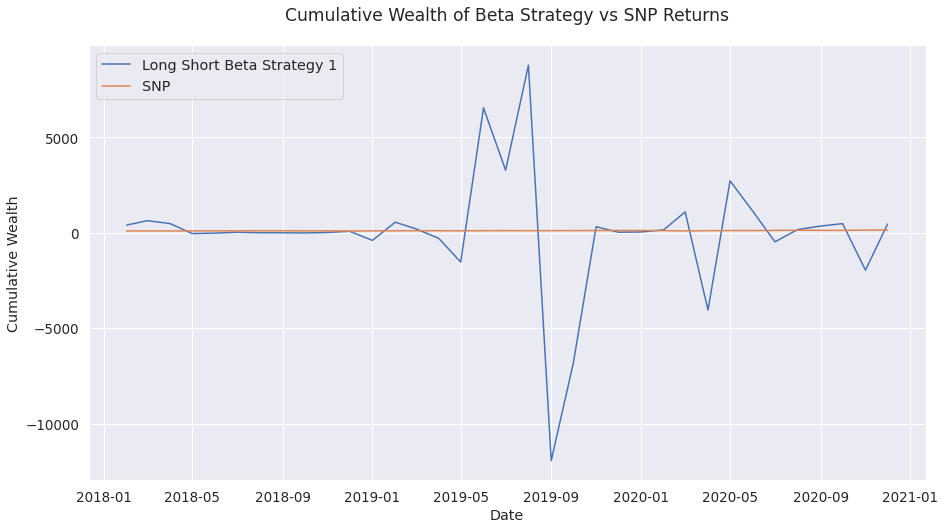

In [34]:
plt.title('Cumulative Wealth of Beta Strategy vs SNP Returns')
plt.plot(portfolio_returns_1['Date'], portfolio_returns_1['Cumulative_Returns'], label = 'Long Short Beta Strategy 1', markersize=3)
plt.plot(snp_returns['Date'], 100 * np.cumprod(1 + snp_returns['Adj Close']), label = 'SNP', markersize=3)
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend(loc='upper left')

plt.show()

Note that Daily Turnover stays 0 for each day during the rebalancing period and spikes up after every rebalancing day due to Portfolio Rebalancing